## **Pytorch on MNIST hand written recognition data set**

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker.

In [3]:
import torch
import torchvision

we'll define the hyperparameters we'll be using for the experiment. Here the number of epochs defines how many times we'll loop over the complete training dataset, while learning_rate and momentum are hyperparameters for the optimizer we'll be using later on.

In [4]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

We'll also need DataLoaders for the dataset. This is where TorchVision comes into play. It let's use load the MNIST dataset in a handy way. We'll use a batch_size of 64 for training and size 1000 for testing on this dataset. The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/tmp/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/tmp/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Now let's take a look at some examples. We'll use the test_loader for this.

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
example_data.shape

torch.Size([1000, 1, 28, 28])

So one test data batch is a tensor of shape: This means we have 1000 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). We can plot some of them using matplotlib.

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

<Figure size 640x480 with 6 Axes>

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Here's an example model. Two 2-D convolutional layers followed by two fully-connected (or linear) layers. For activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

initialize the network and the optimizer.

In [11]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


Time to build our training loop. First we want to make sure our network is in training mode. Then we iterate over all training data once per epoch. Loading the individual batches is handled by the DataLoader. First we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The backward() call collects a new set of gradients which we propagate back into each of the network's parameters using optimizer.step(). For more detailed information about the inner workings of PyTorch's automatic gradient system, see the official docs for autograd.

In [29]:
# utility containers to record how training process goes, used for later visulaztions
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [30]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [31]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Time to run the training! We'll manually add a test() call before we loop over n_epochs to evaluate our model with randomly initialized parameters.

In [32]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/home/walton/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.268458
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.268337
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.273999
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.251667
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.236732
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.223633
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.152995
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.095961
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.974665
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.946313
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.841838
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.768895
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.699720
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687563
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.508094
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.388891
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.291218
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.321653
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.282635
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.391841
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.448315
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.465359
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.412843
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.270387
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.280166
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.484828
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.334954
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.376418
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.324155
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.293631
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.446262
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.194640
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.390015
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.399565
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.290124
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.325451
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.369298
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.632072
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.330763


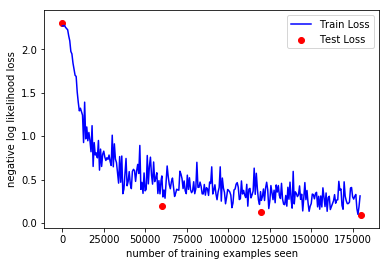

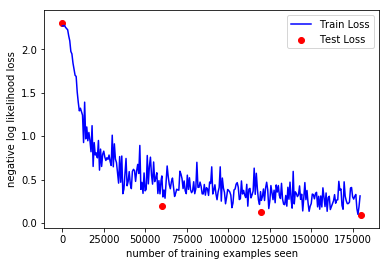

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig